In [258]:
# IMPORTS
# base
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import json
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

In [1]:
usecols = [
    "BindingDB Reactant_set_id",
    # "Ligand SMILES",
    # "Ligand InChI",
    # "Ligand InChI Key",
    # "BindingDB MonomerID",
    # "BindingDB Ligand Name",
    # "Target Name",
    "Target Source Organism According to Curator or DataSource",
    # "Ki (nM)",
    # "IC50 (nM)",
    # "Kd (nM)",
    # "EC50 (nM)",
    # "kon (M-1-s-1)",
    # "koff (s-1)",
    # "pH",
    # "Temp (C)",
    # "Curation/DataSource",
    # "Article DOI",
    # "BindingDB Entry DOI",
    # "PMID",
    # "PubChem AID",
    "Patent Number",
    # "Authors",
    # "Institution",
    # "Ligand HET ID in PDB",
    # "PDB ID(s) for Ligand-Target Complex",
    # "PubChem CID",
    # "PubChem SID",
    # "ChEBI ID of Ligand",
    # "ChEMBL ID of Ligand",
    # "DrugBank ID of Ligand",
    # "IUPHAR_GRAC ID of Ligand",
    # "KEGG ID of Ligand",
    # "ZINC ID of Ligand",
    # "Number of Protein Chains in Target (>1 implies a multichain complex)",
    # "BindingDB Target Chain Sequence",
    # "PDB ID(s) of Target Chain",
    # "UniProt (SwissProt) Recommended Name of Target Chain",
    # "UniProt (SwissProt) Entry Name of Target Chain",
    "UniProt (SwissProt) Primary ID of Target Chain",
    # "UniProt (TrEMBL) Primary ID of Target Chain",
]

In [5]:
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

In [56]:
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "title": patent["info"].get("title", np.nan),
            "abstract": (patent["info"].get("abstract", "") or "").strip(),
            "url": patent["info"].get("url", np.nan),
            "status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)

In [57]:
patents_df["total citations"] = patents_df["families citing"] + patents_df["cited by"]

In [59]:
sorted_top_100 = patents_df.sort_values(by="total citations", ascending=False).head(100)

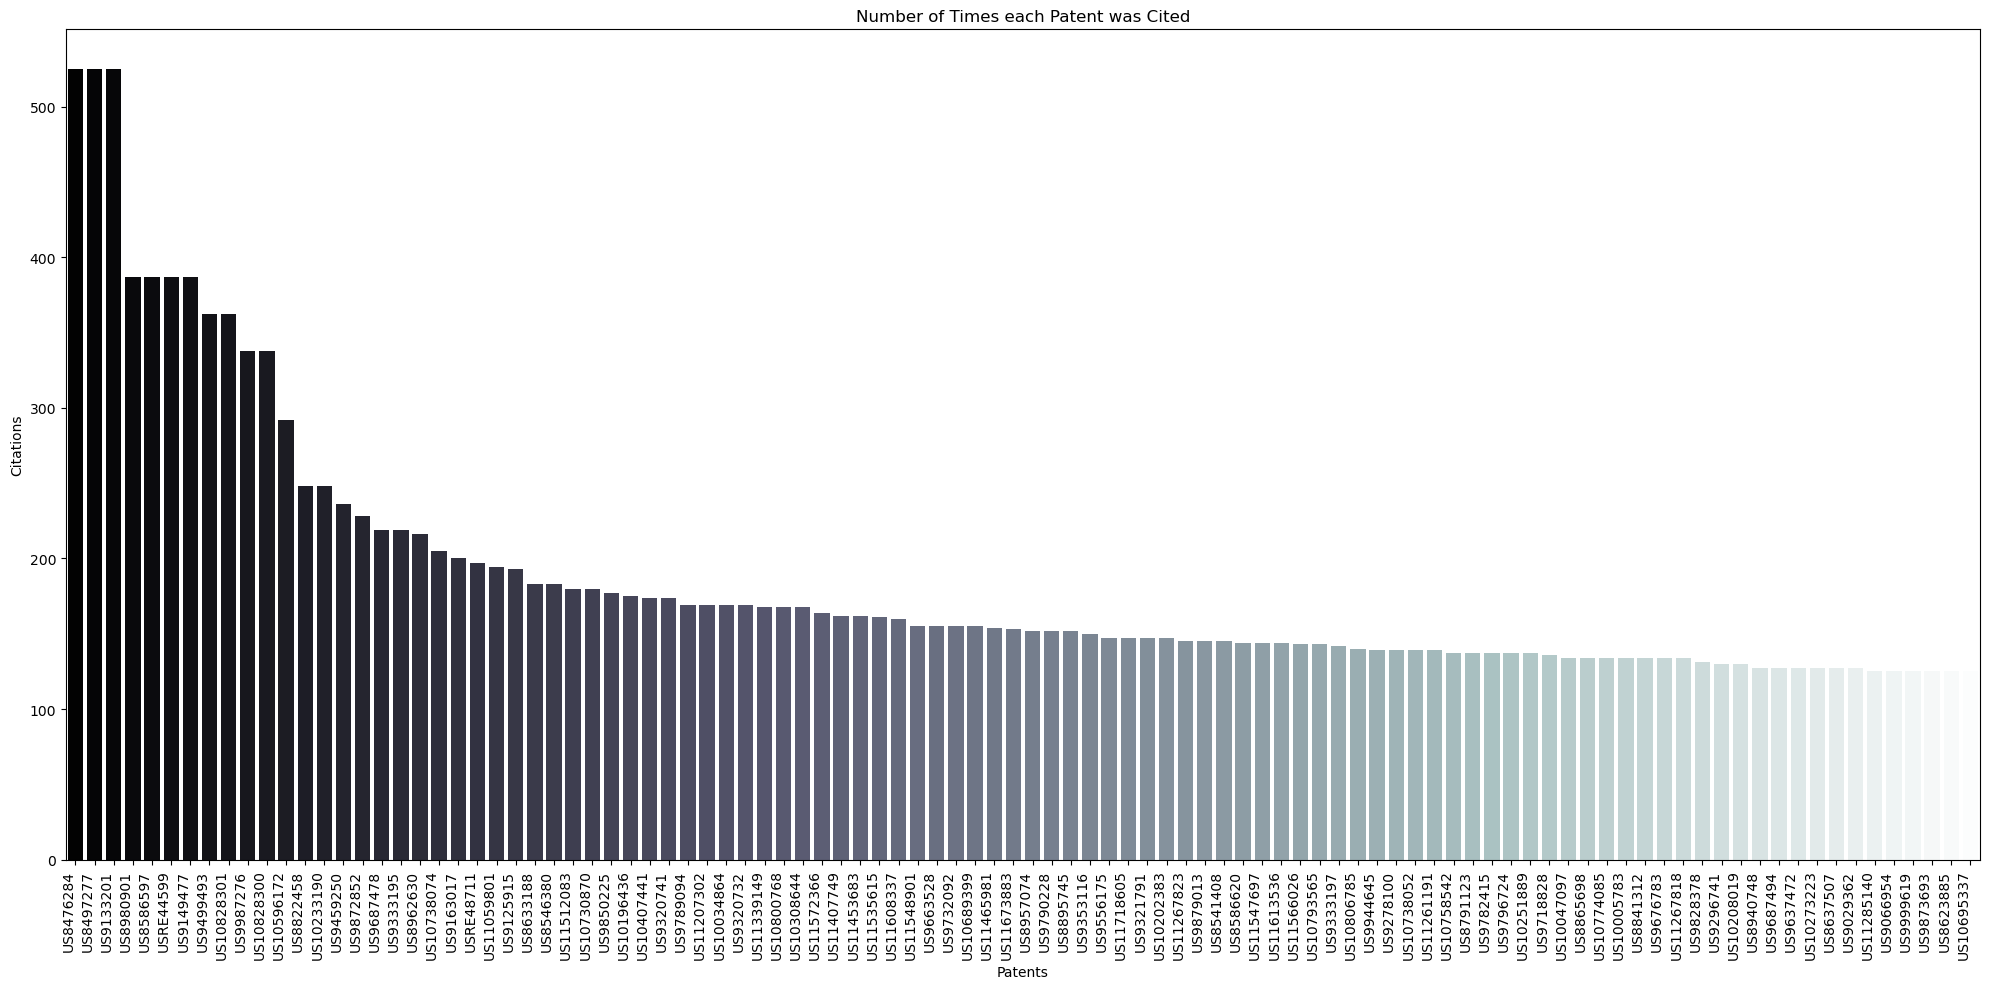

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x="patent", y="total citations", data=sorted_top_100, palette="bone")
# total_mean = patents_df["total citations"].mean()
# total_median = patents_df["total citations"].median()
# plt.axhline(total_mean, color='blue', linestyle='--', label=f"Mean: {total_mean:.2f}")
# plt.axhline(total_median, color='blue', linestyle='-', label=f"Median: {total_median:.2f}")
plt.xticks(rotation=90, ha="right")
plt.xlabel("Patents")
plt.ylabel("Citations")
plt.title("Number of Times each Patent was Cited")
plt.tight_layout()
plt.show()

In [93]:
from src.scripts.disease_plotting import (
    load_uniprotid_diseases,
    quantify_missing_diseases,
    add_keywords_when_comments_missing,
    sort_diseases,
)

diseases = load_uniprotid_diseases()
ids_missing_diseases, percentage_missing = quantify_missing_diseases(diseases)
diseases_df = add_keywords_when_comments_missing(diseases)
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"})
diseases_df = diseases_df.dropna(subset="diseases").drop(
    columns=["comments", "keywords"]
)
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)


def get_patent_citations_per_disease(df, diseases_df, patents_df):
    disease_class_dict = {
        disease_class: set(
            diseases_df[
                diseases_df["Disease Classes"].apply(lambda x: disease_class in x)
            ]["UniProt (SwissProt) Primary ID of Target Chain"]
        )
        for disease_class in set(sum(diseases_df["Disease Classes"], []))
    }
    disease_class_df = pd.DataFrame(
        [
            (disease_class, uniprot_id)
            for disease_class, uniprot_ids in disease_class_dict.items()
            for uniprot_id in uniprot_ids
        ],
        columns=["Disease Classes", "UniProt (SwissProt) Primary ID of Target Chain"],
    )
    bindingDB = df.dropna(subset=["Patent Number"])
    merged_data = bindingDB.merge(
        disease_class_df,
        on="UniProt (SwissProt) Primary ID of Target Chain",
        how="inner",
    )
    disease_patents = (
        merged_data.groupby("Disease Classes")["Patent Number"].apply(set).reset_index()
    )
    disease_patents["Total Citations"] = disease_patents["Patent Number"].apply(
        lambda patents: sum(
            patents_df.loc[patents_df["patent"].isin(patents), "total citations"]
        )
    )
    disease_citations_df = disease_patents.sort_values(
        by="Total Citations", ascending=False
    ).reset_index(drop=True)
    return disease_citations_df


disease_citations_df = get_patent_citations_per_disease(df, diseases_df, patents_df)

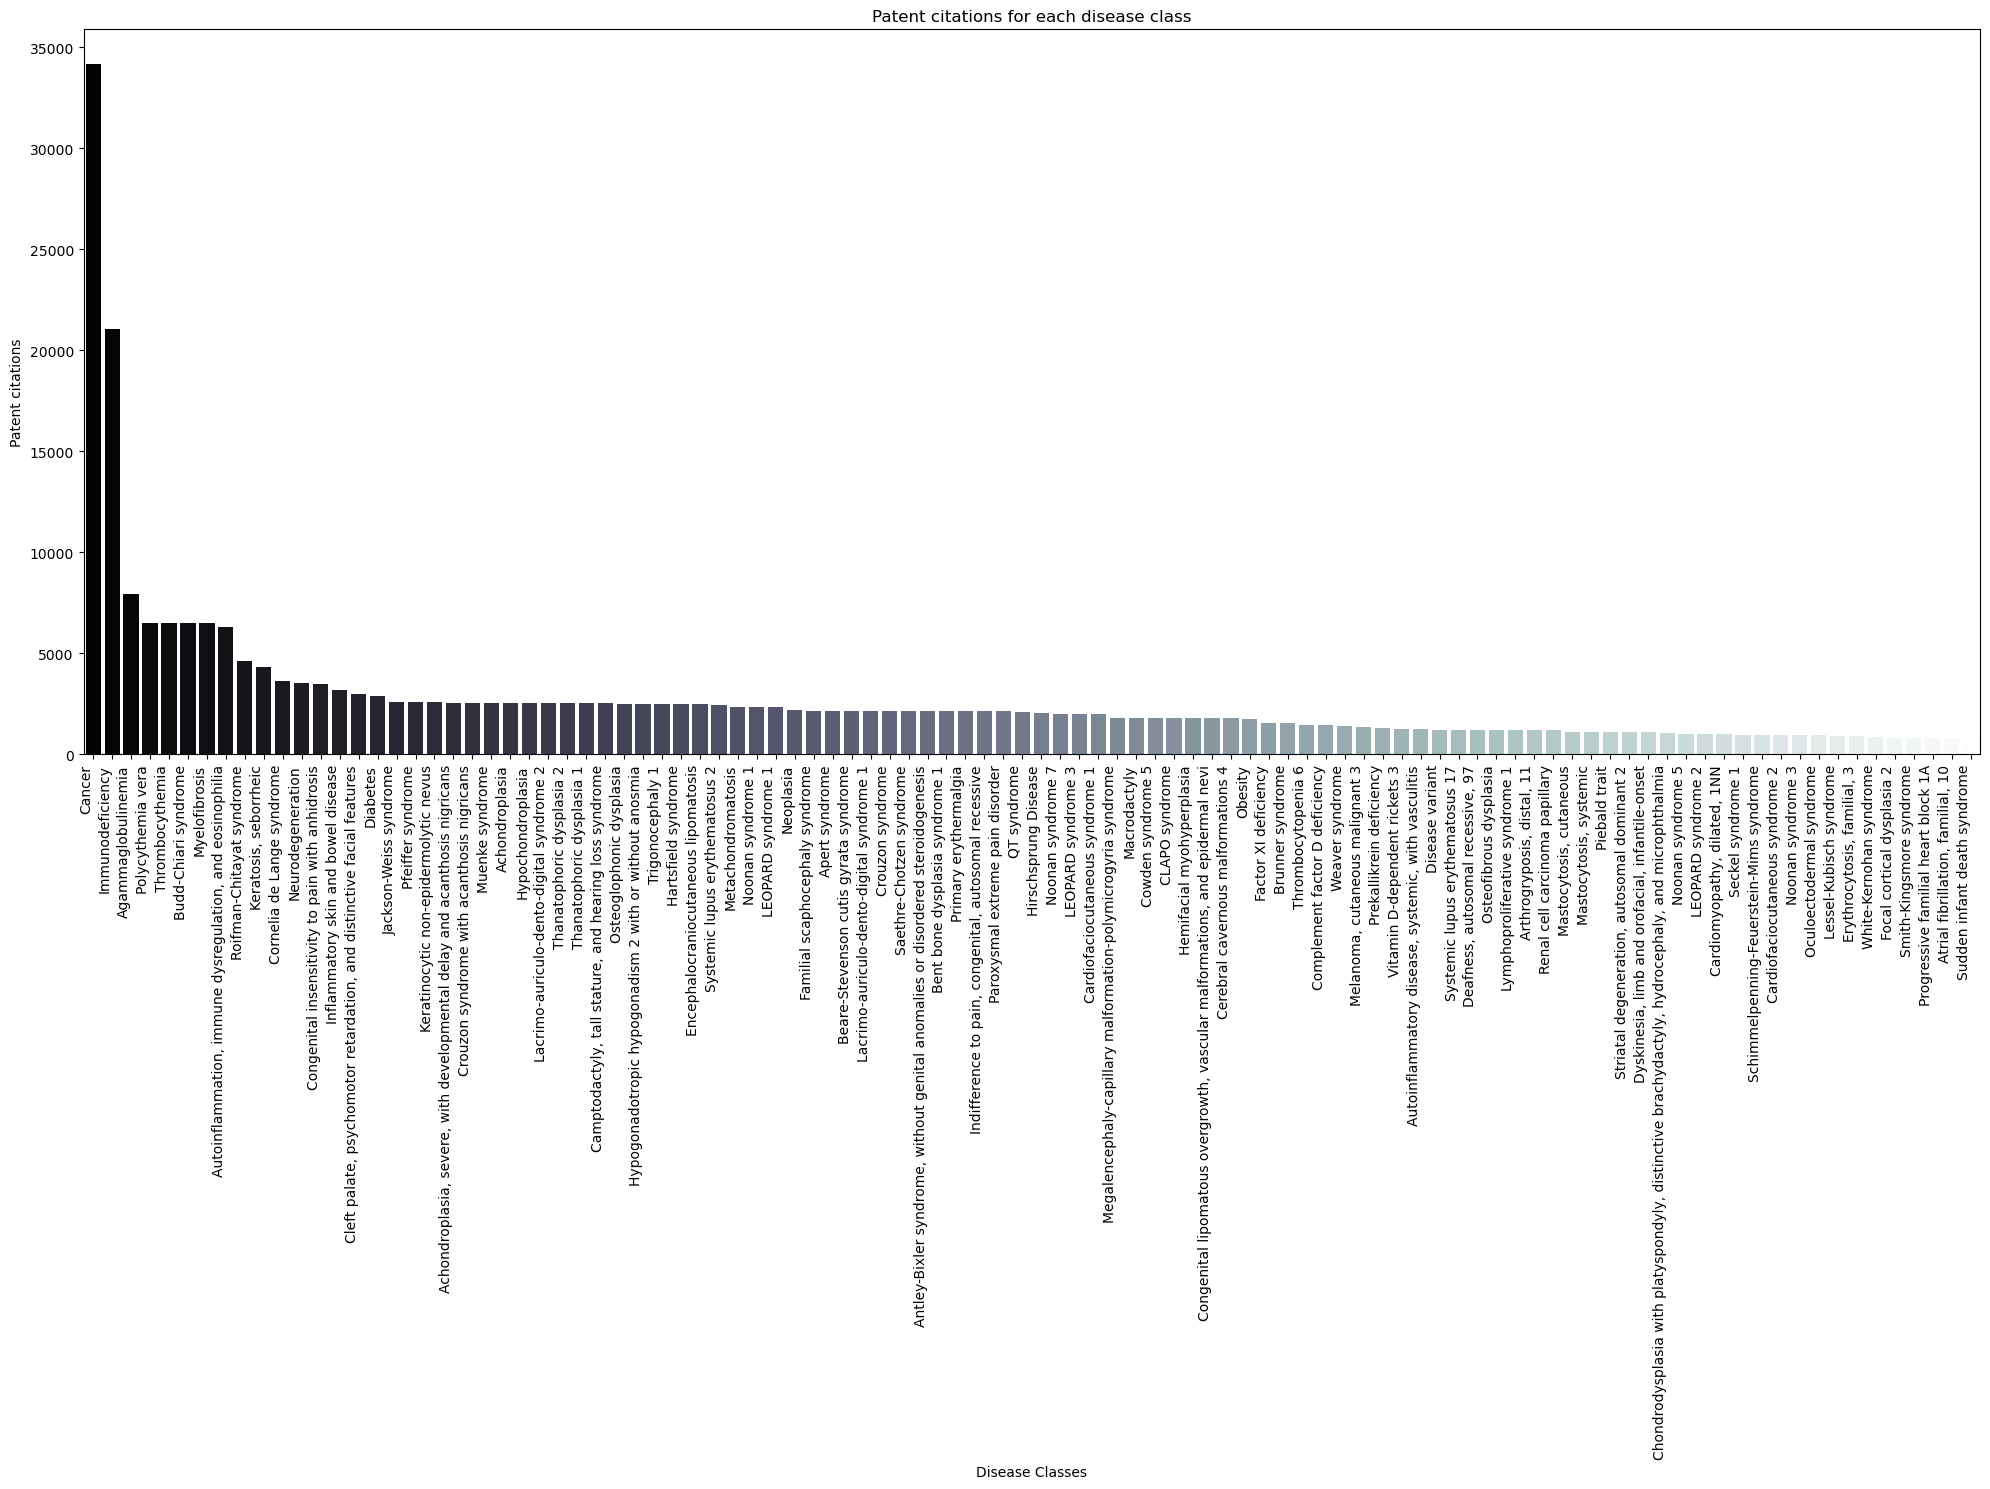

In [100]:
plt.figure(figsize=(20, 15))
sns.barplot(
    x="Disease Classes",
    y="Total Citations",
    data=disease_citations_df.head(100),
    palette="bone",
)
plt.xticks(rotation=90, ha="right")
plt.xlabel("Disease Classes")
plt.ylabel("Patent citations")
plt.title("Patent citations for each disease class")
plt.tight_layout()
plt.show()

In [ ]:
disease_citations_df["Patent status"] = disease_citations_df["Patent Number"].apply(
    lambda patents: list(patents_df.loc[patents_df["patent"].isin(patents), "status"])
)

In [216]:
exploded_df = disease_citations_df.head(100).explode("Patent status")
status_counts = (
    exploded_df.groupby(["Disease Classes", "Patent status"])
    .size()
    .unstack(fill_value=0)
)
status_counts = status_counts.drop(columns=["N/A"])

In [268]:
top_10_diseases = disease_citations_df["Disease Classes"].head(10)
filtered_counts = status_counts.loc[top_10_diseases]
long_data = filtered_counts.reset_index().melt(
    id_vars="Disease Classes", var_name="Patent Status", value_name="Count"
)

In [272]:
fig = px.bar(
    long_data,
    x="Disease Classes",
    y="Count",
    color="Patent Status",
    title="Patent Status for Top 10 Most Cited Diseases",
    color_discrete_sequence=px.colors.sequential.Blues_r,
)
fig.update_layout(
    xaxis_title="Disease Classes",
    yaxis_title="Patent Status Counts",
    legend_title="Patent Status",
    barmode="stack",
    xaxis_tickangle=45,
    width=800,
    height=600,
)
fig.show()

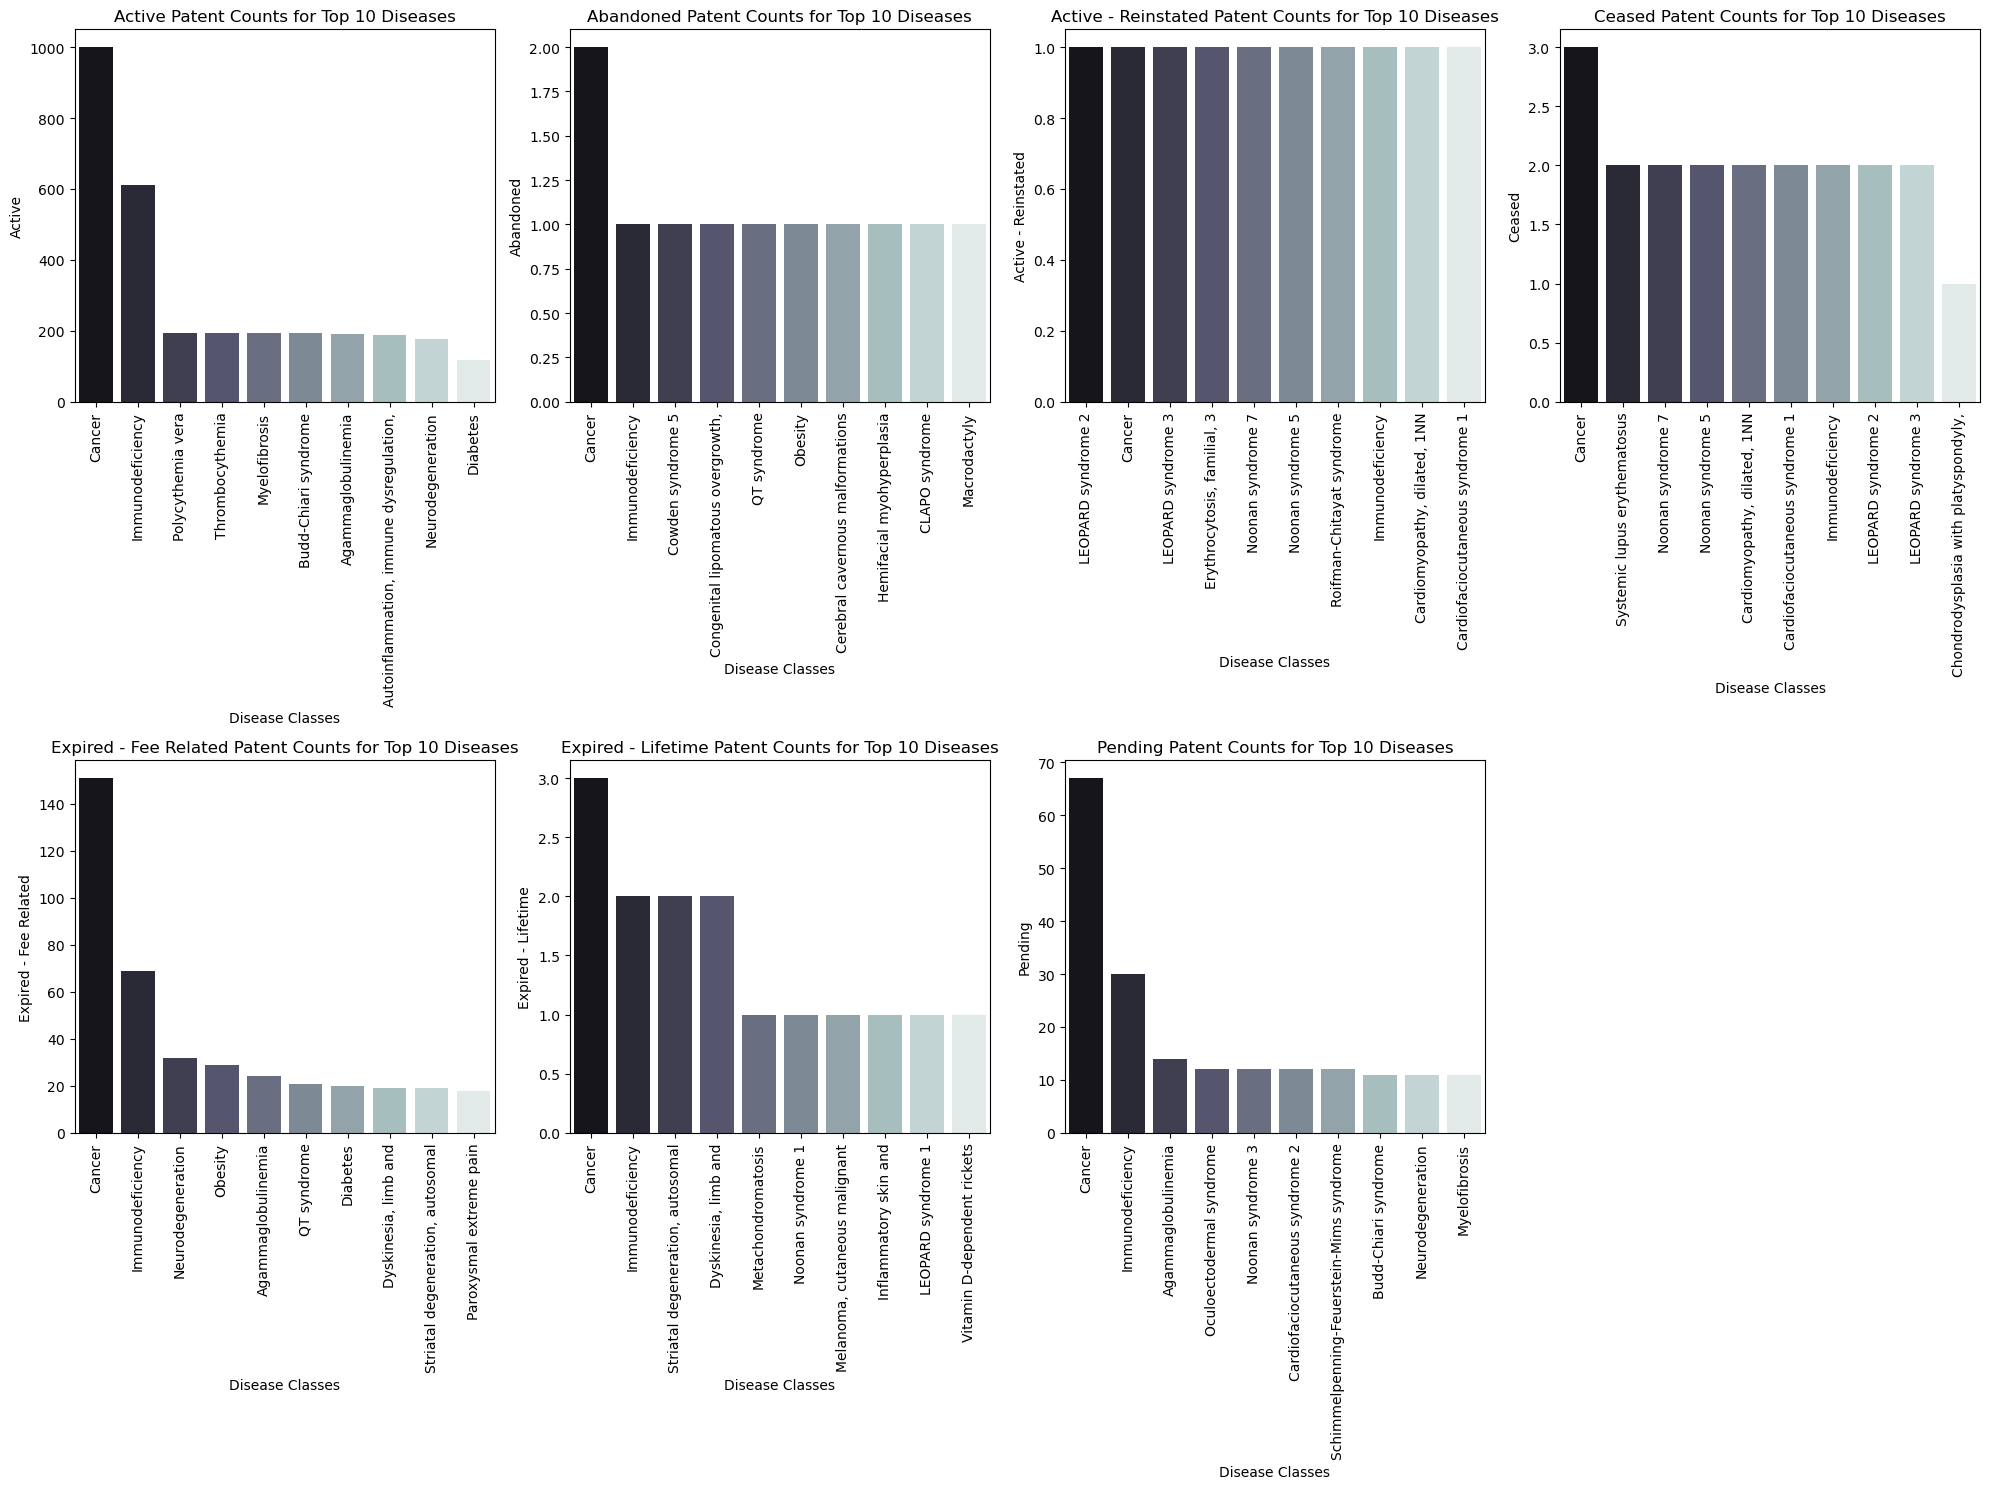

In [ ]:
columns_to_plot = [
    "Active",
    "Abandoned",
    "Active - Reinstated",
    "Ceased",
    "Expired - Fee Related",
    "Expired - Lifetime",
    "Pending",
]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, column in enumerate(columns_to_plot):
    if i >= len(axes):
        break
    sorted_data = status_counts.sort_values(by=column, ascending=False)
    sns.barplot(data=sorted_data[column].head(10), palette="bone", ax=axes[i])
    truncated_labels = [
        " ".join(label.split()[:3]) for label in sorted_data[column].head(10).index
    ]
    axes[i].set_xticklabels(truncated_labels)
    axes[i].set_title(f"{column} Patent Counts for Top 10 Diseases")
    axes[i].tick_params(axis="x", rotation=90)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()